# GTE 102 --- Gas transport equations + utilities + Notes on Uncertainty

#### Version1.2      20/May/2021, Chris Thompson
### Objectives
This is aimed as a walkthrough - how to solve problems using the gas transport equations. The aim is simplicity and clarity; it should be read in conjunction with the lecture notes and worksheet.

> *There is a large body of pedagogic research which shows that students' long term achievement is significantly enhanced if individuals work through problems for themselves rather than copying material.*


Contents:
-   [Introduction](#Intro)
-   [Worksheet: gas pipeline transport](#Worksheet)
   -   [Case 1](#1)
   -   [Case 2](#2)
   -   [Case 3](#3)
-   [Notes on Leaks](#Leaks) (Case 4)
-   [Notes on Uncertainty](#Uncertainty)

 ### <a name="Intro"></a>Introduction
 We have derived the steady transport equation for gas a long a pipeline:
>$ $
\begin{align}
 \left ( \frac{464 S_g}{\pi^2 \overline{R}^2}\right )
  \left ( \frac{P_{st}}{z_{st}T_{st}}\right )^2 
   \frac{fL}{D^5}\dot{Q}_{st}^2 =
  \frac{P_{in}^2-P_{out}^2}{z_{avg} \overline{R} T_{avg}} +
\frac{g P^2_{avg}58 S_g}{z^2_{avg} \overline{R}^2 T^2_{avg}}(H_{in}-H_{out}) 
\end{align}

### Different transmission factors
Different approximations are used for the friction factor $f$. These are applicable to different
flow regimes and pipe diameters. Each gives a different transport formula.  
For simplicity we will consider the AGA (American Gas Association) formula for fully turbulent flow.

- `TFAGA`: The transmission factor used for the AGA equation is:
> $
\frac{1}{\sqrt{f}} = 2 \log_{10}\left (\frac{3.7D}{\epsilon}\right )
$

We substitute this expression into the transport equation above to obtain: 
> $
\dot{Q}_{st} = 13.2986 \frac{T_{st}}{P_{st}}
\left [ \frac{P_1^2-P_2^2-E_{PE}}{L ~S_g~ T_{avg}z_{avg}} \right ] ^{1/2}
\left [ 2\log_{10}\left ( \frac{3.7 D}{\epsilon}\right ) \right ] D^{5/2}
$

For the purposes of this note we write this equation as:

\begin{align*}
{\cal F}(\dot{Q}_{st}, P_{in}, P_{out}, L)
\end{align*}
Simple algebra let's us re-arrange this to make each of the variables the subject of the equation:  
\begin{align}
\dot{Q}_{st} &= {\cal F}_{\dot{Q}_{st}} (P_{in}, P_{out}, L) \\
P_{in} &= {\cal F}_{P_{in}} (\dot{Q}_{st}, P_{out}, L) \\
P_{out} &= {\cal F}_{P_{out}} (\dot{Q}_{st}, P_{in}, L) \\
L &= {\cal F}_{L} (\dot{Q}_{st}, P_{in}, P_{out}) 
\end{align}

#### Validation -- transport equations
-  For clarity we write a function `AGA(Pin, Pout, L)` which returns Qst.  
-  Then we define write a function `AGAGen(Qst, Pin, Pout, L)`.  
  -  One of the arguments shold be set to **-9999**.  
  -  The function will return this value.
- Effectively we have defined the last four (explicit) functions above.

In [8]:
#DEFINE Transport Equations as Qdot = f(Pin, Pout; parameters)
import math
def AGA(P_in, P_out, D, L, S_g, T_avg = 277.2, z_avg = 1, T_st = 288.15, P_st = 1.01325E5, epsilon = 0.046E-3, EPE = 0, DEBUG = 0):
    """
    AGA(P_in,P_out,D,L,S_g, T_avg = 277.2K, z_avg = 1, T_st = 288.15K, P_st = 1.01325E5Pa, EPE = 0)
    - use the AGA  formula to generate Qdot_st from P_in, P_out, D(iameter), L(ength) etc.
    Qdot in standard cubic metres per second.
    """
    T1 = 13.2986 * (T_st/P_st)*pow(D,5/2)
    denom = S_g * T_avg *z_avg
    trans = 2*math.log10(3.7*D/epsilon)
    T2 = (pow(P_in,2) - pow(P_out,2) - EPE)/(L* S_g * T_avg *z_avg)
    Q_st = T1*trans*pow(T2,1/2)
    #print("AGA-denom:",denom,"trans:",trans,"T1",T1,"T2",T2)
    return Q_st


AGAF = AGA(9E6,2E6, 0.34, 1.6E5, 0.693)
print("Validate AGA function.")
print("Flow rate - using AGA:      ", '{:12.4e}'.format(AGAF),"SCM/sec", " = ",'{:12.4e}'.format((AGAF*24*3600)/1E6),"MSCM/day");
print(AGA.__doc__)#Just show how the documentation method works.

Validate AGA function.
Flow rate - using AGA:         3.5805e+01 SCM/sec  =    3.0935e+00 MSCM/day

    AGA(P_in,P_out,D,L,S_g, T_avg = 277.2K, z_avg = 1, T_st = 288.15K, P_st = 1.01325E5Pa, EPE = 0)
    - use the AGA  formula to generate Qdot_st from P_in, P_out, D(iameter), L(ength) etc.
    Qdot in standard cubic metres per second.
    


In [5]:
#DEFINE AGA Transport Equations as RetCode = f(Qdot, Pin, Pout,L; parameters)
#Syntax: OUTPUT variable is initialised to -9999.
#This works because, in real life everything must be positive.
#Example:{Qdot, Pin, Pout,L} 
#  Legal examples: {-9999, Pin>Pout, Pout>0,L}- find Qdot
#                  {Qin>0,-Pin,-9999,L} find Pout by varying Pin

def AGAGen(Qdot, Pin, Pout, L, D, Sg, 
           Tavg = 277.2, zavg = 1, Tst=288.15, Pst=1.01325E5, epsilon = 0.046E-3, EPE=0, Const=137.2364,
           DEBUG = 0):
    """
    AGAGen(Qdot, Pin, Pout, L, D, Sg, 
           Tavg = 277.2K, zavg = 1, Tst = 288.15K, Pst = 1.01325E5Pa, epsilon = 0.046E-3, EPE = 0)
    - the AGA (turb) formula to generate one of {Qdot_st, Pin, Pout, L} - given the other three.
    The unknown is specified by a value of -9999. 
    We use PARAMS: [D(iameter), Sg].
    Qdot in standard cubic metres per second.
    """
    #Only one of Qdot, Pin, Pout, L should be -9999
    import math
    MainArgs = [Qdot, Pin, Pout, L]
    PARAMS = [D, Sg]
    if not (MainArgs.count(-9999) == 1): 
        print("Error - only one argument shout be -9999")
        return -9999
    T1 = 13.2986 * (Tst/Pst)*(2*math.log10(3.7*D/epsilon))*pow(D,5/2)
    denom = Sg * Tavg *zavg
    if Qdot == -9999 :
        if DEBUG == 1 : print("AGA to find Qdot. Pin: ", '{:12.3e}'.format(Pin), " Pout: ", '{:12.3e}'.format(Pout))
        Qst = T1*math.sqrt((Pin**2 - Pout**2 - EPE)/(L*denom))
        return Qst
    elif Pin == -9999:
        if DEBUG == 1 : print("AGAGen to find Pin. Qdot: ", '{:12.3e}'.format(Qdot), " Pout: ", '{:12.3e}'.format(Pout))
        PinSq = L*denom*(Qdot/T1)**2 + Pout**2 + EPE
        Pin = math.sqrt(PinSq)
        if DEBUG == 1 : print("In AGAGen!!: ", Qdot,Pin)
        return Pin
    elif Pout == -9999:
        if DEBUG == 1 : print("AGAGen to find Pout. Qdot: ", '{:12.3e}'.format(Qdot), " Pin: ", '{:12.3e}'.format(Pin))
        PoutSq = Pin**2 - L*denom*(Qdot/T1)**2 - EPE
        Pout = math.sqrt(PoutSq)
        return Pout
    elif L == -9999:
        T2 = (pow(Pin,2) - pow(Pout,2) - EPE)/denom
        L = (T1/Qdot)**2 * T2
        return L
    return "ERROR"


#ANSWER Weymouth(34.25483928234368 , 9E6, 2E6,165km)(from previous Jupyter notebook.)
#               ,D,Sg,zavg=1,Tst=288.15,Pst=1.01325E5,EPE = 0)
print(AGAGen(-9999 , 9E6, 2E6, 1.65E5, 0.34, 0.693, DEBUG = 0), " Weymouth: ", 34.25483928234368)#CORRECT
print(AGAGen(34.25483928234368 , -9999, 2E6, 1.65E5, 0.34, 0.693, DEBUG = 0), " Weymouth: ", 9.0E6)#CORRECT
print(AGAGen(34.25483928234368 , 9E6, -9999, 1.65E5, 0.34, 0.693, DEBUG = 0), " Weymouth: ", 2.0E6)#CORRECT
print(AGAGen(34.25483928234368 , 9E6, 2E6, -9999, 0.34, 0.693, DEBUG = 0), " Weymouth: ", 1.65E5)#CORRECT

35.25796615574416  Weymouth:  34.25483928234368
8756761.036884634  Weymouth:  9000000.0
2884291.2722017444  Weymouth:  2000000.0
174805.29709965378  Weymouth:  165000.0


### <a name="Worksheet"></a>Now for the worksheet
#### <a name="1"></a>Case 1
A horizontal, natural gas pipeline, made of DN 350 Schedule 20 pipe, is 160km long.  
The inlet pressure (Point A) is 90 bara and the outlet pressure (Point B) is 20 bara; the average gas temperature is $4^\circ$C.  
The gas consists of 75% methane, 21% ethane and 4% propane.

Use the simplified isothermal flow equation to calculate the flow rate in standard cubic metres per day.
(Recall that the specification DN350 means that the diameter of this pipe is 340mm.)

> *For simplicity we'll do these cases using the AGA equation for fully turbulent flow.*

In [4]:
#Case 1 - using AGA
print(AGAGen(-9999, 9E6, 2E6, 1.60E5, 0.34, 0.693), "SCM/sec")
print(AGAGen(-9999, 9E6, 2E6, 1.60E5, 0.34, 0.693)*3600*24, "SCM/day")


35.80463388982756 SCM/sec
3093520.3680811008 SCM/day


#### <a name="2"></a>Case 2
The above pipe has a second pipe constructed alongside to increase the flow capacity.
We now have a simple 'network' of two horizontal gas pipelines connecting two manifolds.
The distance between the manifolds is 100km.
The diameter of Pipe AB is 350mm, the diameter of Pipe CD is 400mm.
 
Given that the outlet pressure is 20bara, find the inlet pressure so that the combined volumetric flow rate in the two pipes sums to $6 \times 10^6$ standard cubic metres per day.

What is the flow rate in each pipe?

>_In this case we have two pipes (of different diameters).  
The inlet and outlet pressures are the same. **Why?**  
We end up with two non-linear, algebraic equations:_  
\begin{align}
P^{[1]}_{in} &= {\cal F}_{P_{in}} (\dot{Q}^{[1]}_{st}, P_{out}, 100km) \\
P^{[2]}_{in} &= {\cal F}_{P_{in}} (\dot{Q}^{[2]}_{st}, P_{out}, 100km) \\
\textsf{We know the value of the outlet pressure: } P_{out} &= 2\times10^6\\
\textsf{We also have two constraints to satisfy: }\\
P^{[1]}_{in} &= P^{[2]}_{in} \\
\dot{Q}^{[1]}_{st} + \dot{Q}^{[2]}_{st} &= \frac{6.0\times 10^6}{3600 \times 24}
\end{align}
_There are different ways to solve these equations, we use an iterative scheme, coded explicitly.  
The scheme is simply linear interpolation.  
This converges quickly, but we need to establish a bracket -  
in this case there are obvious choices.
**How do these initial guesses work?**_

In [6]:
#Case 2
def TwinPipes(TotFlow, DEBUG = 1):
    #Initialize
    Q1m = 0.5*TotFlow; Q1p = TotFlow
    #PIPE1:
    Pin1m = AGAGen(Q1m, -9999, 2E6, 1.00E5, 0.35, 0.693)
    Pin1p = AGAGen(Q1p, -9999, 2E6, 1.00E5, 0.35, 0.693)
    #PIPE2:
    Q2m = TotFlow - Q1m
    Pin2m = AGAGen(Q2m, -9999, 2E6, 1.00E5, 0.40, 0.693)
    Q2p = TotFlow - Q1p
    Pin2p = AGAGen(Q2p, -9999, 2E6, 1.00E5, 0.40, 0.693)
    if DEBUG == 1:
        print("init- "," Pin1m: ", '{:12.3e}'.format(Pin1m), " Q1m: ", '{:12.3e}'.format(Q1m))
        print("init- "," Pin2m: ", '{:12.3e}'.format(Pin2m), " Q2m: ", '{:12.3e}'.format(Q2m))
        print("init- "," Pin1p: ", '{:12.3e}'.format(Pin1p), " Q1p: ", '{:12.3e}'.format(Q1p))
        print("init- "," Pin2p: ", '{:12.3e}'.format(Pin2p), " Q2p: ", '{:12.3e}'.format(Q2p))
    
    for i in range(0,20):
        DPp = Pin1p - Pin2p; DPm = Pin1m - Pin2m;
        Q1star = Q1p - (Q1p-Q1m)*(DPp - 0)/(DPp-DPm)
        if DEBUG == 1: print("Q1p,Q1star,Q1m: ",'{:12.3e}'.format(Q1p), '{:12.3e}'.format(Q1star),'{:12.3e}'.format(Q1m),
          " Pin1p,DPp,DPm: ", '{:12.3e}'.format(Pin1p), '{:12.3e}'.format(DPp), '{:12.3e}'.format(DPm))
        Q1p = Q1m;
        Q1m = Q1star;
        #PIPE1:
        Pin1m = AGAGen(Q1m, -9999, 2E6, 1.00E5, 0.35, 0.693)
        Pin1p = AGAGen(Q1p, -9999, 2E6, 1.00E5, 0.35, 0.693)
        #PIPE2:
        Q2m = TotFlow - Q1m
        Pin2m = AGAGen(Q2m, -9999, 2E6, 1.00E5, 0.40, 0.693)
        Q2p = TotFlow - Q1p
        Pin2p = AGAGen(Q2p, -9999, 2E6, 1.00E5, 0.40, 0.693)
        if DEBUG == 1:
            print("i- ", i, " Pin1m: ", '{:12.3e}'.format(Pin1m), " Q1m: ", Q1m)
            print("i- ", i, " Pin2m: ", '{:12.3e}'.format(Pin2m), " Q2m: ", Q2m)
            print("i- ", i, " Pin1p: ", '{:12.3e}'.format(Pin1p), " Q1p: ", Q1p)
            print("i- ", i, " Pin2p: ", '{:12.3e}'.format(Pin2p), " Q2p: ", Q2p)
        if abs(DPp/Pin1p) < 10.0E-5: 
            print("TwinPipes success - Pin: ", '{:12.3e}'.format(Pin1p))
            return Pin1p

TwP = TwinPipes(6.0E6/(3600*24))
print("Output from TwinPipes - inlet pressure: ", '{:12.3e}'.format(TwP))
print("AGAGen Pipe 1 - Flow rate: ", '{:12.3e}'.format(24*3600*AGAGen(-9999, TwP, 2E6, 1.00E5, 0.35, 0.693)))
print("AGAGen Pipe 2 - Flow rate: ", '{:12.3e}'.format(24*3600*AGAGen(-9999, TwP, 2E6, 1.00E5, 0.40, 0.693)))
print("Total DAILY flow rate: ", 
      '{:12.3e}'.format(24*3600*(AGAGen(-9999, TwP, 2E6, 1.00E5, 0.35, 0.693) + AGAGen(-9999, TwP, 2E6, 1.00E5, 0.40, 0.693))))


init-   Pin1m:     6.552e+06  Q1m:     3.472e+01
init-   Pin2m:     4.843e+06  Q2m:     3.472e+01
init-   Pin1p:     1.264e+07  Q1p:     6.944e+01
init-   Pin2p:     2.000e+06  Q2p:     0.000e+00
Q1p,Q1star,Q1m:     6.944e+01    2.808e+01    3.472e+01  Pin1p,DPp,DPm:     1.264e+07    1.064e+07    1.709e+06
i-  0  Pin1m:     5.427e+06  Q1m:  28.0771576603479
i-  0  Pin2m:     5.623e+06  Q2m:  41.36728678409654
i-  0  Pin1p:     6.552e+06  Q1p:  34.72222222222222
i-  0  Pin2p:     4.843e+06  Q2p:  34.72222222222222
Q1p,Q1star,Q1m:     3.472e+01    2.876e+01    2.808e+01  Pin1p,DPp,DPm:     6.552e+06    1.709e+06   -1.956e+05
i-  1  Pin1m:     5.542e+06  Q1m:  28.75977106326443
i-  1  Pin2m:     5.542e+06  Q2m:  40.68467338118001
i-  1  Pin1p:     5.427e+06  Q1p:  28.0771576603479
i-  1  Pin2p:     5.623e+06  Q2p:  41.36728678409654
Q1p,Q1star,Q1m:     2.808e+01    2.876e+01    2.876e+01  Pin1p,DPp,DPm:     5.427e+06   -1.956e+05   -4.640e+02
i-  2  Pin1m:     5.542e+06  Q1m:  28.76139388

#### <a name="3"></a>Case 3
The above double pipe is extended by a single pipeline EF of diameter 500mm. The distance E to F is 150km. The point F is 300m higher than E. The temperature of points A(=C) and B (=D=E) is $20^\circ$C. The temperature at point F is $4^\circ$C.
 
If the inlet pressure 85 bara and the outlet pressure is 20 bara calculate the flow rate in each pipe and the pressure at Point E.

>_For simplicity we ignore the change in potential energy.  
In this case we have three pipes (of different diameters).  
The arrangement of the manifolds determines the relationship between the pressures. **Is this clear to you?**  
We end up with four non-linear, algebraic equations:_  
\begin{align}
P^{[1]}_{out} &= {\cal F}_{P_{in}} (\dot{Q}^{[1]}_{st}, P^{[1]}_{out}, 100km) \\
P^{[2]}_{out} &= {\cal F}_{P_{in}} (\dot{Q}^{[2]}_{st}, P^{[2]}_{out}, 100km) \\
P^{[3]}_{in} &= {\cal F}_{P_{in}} (\dot{Q}^{[3]}_{st}, P^{[3]}_{out}, 100km)
\end{align}
We know the value of the inlet pressure: $P^{[1]}_{in} = P^{[2]}_{in} = 85$bara  
We know the value of the outlet pressure: $P^{[3]}_{out} = 20$bara  
We also have the constraints:  
\begin{align}
P^{[1]}_{out} &= P^{[2]}_{out} = P^{[3]}_{in}  ~ ~ ~(=P_{mid})\\
\dot{Q}^{[1]}_{st} + \dot{Q}^{[2]}_{st} &= \dot{Q}^{[3]}_{st}
\end{align}
_There are different ways to solve these equations, we use the same approach as above._

In [7]:
#Case 3 :)
#Case 3.1 - Assume everything is at the same temperature and height.

def ThreePipes(TotFlow, DEBUG = 0):
    #Initialize
    Pmidp = 2*8.5E6/3+2.0E6/3
    Pmidm = 8.5E6/3 + 2*2.0E6/3
    #PIPE1:
    Q1m = AGAGen(-9999, 8.5E6, Pmidm, 1.00E5, 0.35, 0.693)
    Q1p = AGAGen(-9999, 8.5E6, Pmidp, 1.00E5, 0.35, 0.693)
    #PIPE2:
    Q2m = AGAGen( -9999, 8.5E6, Pmidm, 1.00E5, 0.40, 0.693)
    Q2p = AGAGen( -9999, 8.5E6, Pmidp, 1.00E5, 0.40, 0.693)
    #PIPE3:
    Q3m = AGAGen( -9999, Pmidm, 2E6, 1.50E5, 0.40, 0.693)
    Q3p = AGAGen( -9999, Pmidp, 2E6, 1.50E5, 0.40, 0.693)

    for i in range(1,20):
        if DEBUG == 1:
            print("i- ",i," Pmid1m: ", '{:12.3e}'.format(Pmidm), " Q1m: ", '{:12.3e}'.format(Q1m))
            print("i- ",i," Pmid2m: ", '{:12.3e}'.format(Pmidm), " Q2m: ", '{:12.3e}'.format(Q2m))
            print("i- ",i," Pmid1p: ", '{:12.3e}'.format(Pmidp), " Q1p: ", '{:12.3e}'.format(Q1p))
            print("i- ",i," Pmid2p: ", '{:12.3e}'.format(Pmidp), " Q2p: ", '{:12.3e}'.format(Q2p))
            print("i- ",i," Pmid3m: ", '{:12.3e}'.format(Pmidm), " Q3p: ", '{:12.3e}'.format(Q3m))
            print("i- ",i," Pmid3p: ", '{:12.3e}'.format(Pmidp), " Q3p: ", '{:12.3e}'.format(Q3p))
        #First calculate the flow rate through the twin pipes and the outlet pipe (3):
        Q1m = AGAGen(-9999, 8.5E6, Pmidm, 1.00E5, 0.35, 0.693)
        Q2m = AGAGen(-9999, 8.5E6, Pmidm, 1.00E5, 0.40, 0.693)
        Q3m = AGAGen(-9999, Pmidm, 2.0E6, 1.50E5, 0.50, 0.693)
        ErrQm = Q3m - ( Q1m + Q2m)
        Q1p = AGAGen(-9999, 8.5E6, Pmidp, 1.00E5, 0.35, 0.693)
        Q2p = AGAGen(-9999, 8.5E6, Pmidp, 1.00E5, 0.40, 0.693)
        Q3p = AGAGen(-9999, Pmidp, 2.0E6, 1.50E5, 0.50, 0.693)
        ErrQp = Q3p - ( Q1p + Q2p)
        PmidStar = Pmidm - (Pmidm - Pmidp)*(ErrQm - 0)/(ErrQm - ErrQp)
        Pmidm = Pmidp
        Pmidp = PmidStar
        if abs(ErrQp/Q3p) < 10.0E-5: 
            print("ThreePipes success - Pmid: ", '{:12.3e}'.format(Pmidp))
            return Pmidp
    return "ERROR"



T3P = ThreePipes(6.0E6/(3600*24), DEBUG = 0)
print("Output from ThreePipes - mid-manifold pressure: ", '{:12.3e}'.format(T3P))
print("AGAGen Pipe 1 - Flow rate: ", 24*3600*AGAGen(-9999, 8.5E6, T3P, 1.00E5, 0.35, 0.693))
print("AGAGen Pipe 2 - Flow rate: ", 24*3600*AGAGen(-9999, 8.5E6, T3P, 1.00E5, 0.40, 0.693))
print("AGAGen Pipe 3 - Flow rate: ", 24*3600*AGAGen(-9999, T3P, 2.0E6, 1.50E5, 0.50, 0.693))

print("Total INPUT to mid-manifold flow rate: ", 
      24*3600*((AGAGen(-9999, 8.5E6, T3P, 1.00E5, 0.35, 0.693) + AGAGen(-9999, 8.5E6, T3P, 1.00E5, 0.40, 0.693))))


ThreePipes success - Pmid:     6.594e+06
Output from ThreePipes - mid-manifold pressure:     6.594e+06
AGAGen Pipe 1 - Flow rate:  2578808.259980748
AGAGen Pipe 2 - Flow rate:  3647729.735208989
AGAGen Pipe 3 - Flow rate:  6226537.9979890315
Total INPUT to mid-manifold flow rate:  6226537.9951897375


In [8]:
#Case 3 :) Re-do with fsolve.
#Case 3.1 - Assume everything is at the same temperature and height.
from scipy import optimize
def func3pipes(x, PARAMS):
    DEBUG = PARAMS[0]
    if DEBUG == 1:
        print("func3pipes - x:",'{:9.3e}'.format(x[0]))#," 8.5E6":",'{:9.3e}'.format(x[0]))
    Pmidm = x[0]
    Q1 = AGAGen(-9999, 8.5E6, Pmidm, 1.00E5, 0.35, 0.693, DEBUG = 0)
    Q2 = AGAGen(-9999, 8.5E6, Pmidm, 1.00E5, 0.40, 0.693)
    Pmid3 = AGAGen(Q1+Q2, -9999, 2.0E6, 1.50E5, 0.50, 0.693)
    #Do I need to have an estimate for the error in P at the middle - guess not!
    error = Pmid3-Pmidm
    if DEBUG == 1:
        print ("err:",'{:9.3e}'.format(error),", Q1: ",'{:10.3e}'.format(Q1),
                   ", Q2: ",'{:10.3e}'.format(Q2),", Pmid3:",'{:10.3e}'.format(Pmid3),
                   ", x:", '{:9.3e}'.format(x[0]))
    return error
def ThreePipes(TotFlow, DEBUG = 0):
    #Initialize (pressure at the central manifold)
    Pmid0 = 8.5E6/3 + 2*2.0E6/3
#Initial guesses:
    x0 = Pmid0
    PARAMS = [DEBUG]
    x = optimize.fsolve(func3pipes, x0,PARAMS,full_output=0,xtol=1.49012e-08)
    return x[0]



T3P = ThreePipes(6.0E6/(3600*24), 0)
Q1PerDay = 24*3600*AGAGen(-9999, 8.5E6, T3P, 1.00E5, 0.35, 0.693)
Q2PerDay = 24*3600*AGAGen(-9999, 8.5E6, T3P, 1.00E5, 0.40, 0.693)
Q3PerDay = 24*3600*AGAGen(-9999, T3P, 2.0E6, 1.50E5, 0.50, 0.693)
print("   leak", Q3PerDay*.99)
print("   DP=",(T3P-2.0E6)*.99)
print("Output from ThreePipes - mid-manifold pressure: ", '{:9.4e}'.format(T3P))
print("AGAGen Pipe 1 - Flow rate: ", '{:9.4e}'.format(Q1PerDay),"SCMPD")
print("AGAGen Pipe 2 - Flow rate: ", '{:9.4e}'.format(Q2PerDay),"SCMPD")
print("AGAGen Pipe 3 - Flow rate: ", '{:9.4e}'.format(Q3PerDay),"SCMPD")

print("Total INPUT to mid-manifold flow rate: ", 
      24*3600*((AGAGen(-9999, 8.5E6, T3P, 1.00E5, 0.35, 0.693) + AGAGen(-9999, 8.5E6, T3P, 1.00E5, 0.40, 0.693))))


   leak 6164272.616840874
   DP= 4548214.129555363
Output from ThreePipes - mid-manifold pressure:  6.5942e+06
AGAGen Pipe 1 - Flow rate:  2.5788e+06 SCMPD
AGAGen Pipe 2 - Flow rate:  3.6477e+06 SCMPD
AGAGen Pipe 3 - Flow rate:  6.2265e+06 SCMPD
Total INPUT to mid-manifold flow rate:  6226537.996809379


### Using the Colebrook-White Drag law

Let's do this again using the simple isothermal transport equation 
with a definition of $f$ throught the full Colebrook-White drag law.

`TFColebrook`: The Colebrook-White formula for transmission factor is:
> $
\frac{1}{\sqrt{f}} = -2.0 \log_{10} \left [ \frac{\epsilon}{3.7D} + \frac{2.51}{Re \sqrt{f}}\right ]
$

Arguably this is the most general and robust formula for the transmission factor.  
It is a little more difficult to use because the formula is implicit but a Picard (fixed point) iteration converges very quickly and does not seem to be sensitive to starting estimate.  
The function `QdotCW` handles this iteration.

In [9]:
#DEFINE Simplified Isothermal Transport Equations as RetCode = f(Qdot, Pin, Pout,L; parameters)
#Syntax: OUTPUT variable is initialised to -9999.
#This works because, in real life everything must be positive.
#Example:{Qdot, Pin, Pout,L} 
#  Legal examples: {-9999, Pin>Pout, Pout>0,L}- find Qdot
#                  {Qin>0,-Pin,-9999,L} find Pout by varying Pin

import math
from scipy import optimize
def SITGen(Qdot, Pin, Pout, L, fold, D, Sg, 
           Tavg = 277.2, zavg = 1, Tst=288.15, Pst=1.01325E5, epsilon = 0.046E-3, EPE=0, Const=137.2364,
           DEBUG = 0):
    """
    SITGen(Qdot, Pin, Pout, L, f, D, Sg, 
           Tavg=277.2K, zavg=1, Tst=288.15K, Pst=1.01325E5Pa, epsilon=0.046E-3, EPE = 0)
    - use Simplified Isothermal Transport (SIT) formula to generate one of Qdot_st, Pin, Pout, L - given the other three.
    The unknown is specified by a value of -9999. 
    We use PARAMS: [D(iameter), Sg].
    Qdot in standard cubic metres per second.
    """
    #Only one of Qdot, Pin, Pout, L should be -9999
    MainArgs = [Qdot, Pin, Pout, L, fold]
    PARAMS = [D, Sg]

    if not (MainArgs.count(-9999) == 1): 
        print("Error - only one argument shout be -9999")
        return -9999
    #Compute some terms in the transmission formula.
    T1 = 13.2986 * (Tst/Pst)*pow(D,5/2)
    denom = Sg * Tavg *zavg
    PARAMSCW = [Pin,Pout,L,epsilon,D,Sg,EPE, T1,denom]
    f = CWf(Qdot,0.0128,PARAMSCW)

    if Qdot == -9999:
        return QdotCW(Qdot,f,PARAMSCW)
    elif Pin == -9999:
        if DEBUG == 1 : print("SITGen to find Pin. Qdot: ", '{:12.3e}'.format(Qdot), " Pout: ", '{:12.3e}'.format(Pout))
        PinSq = f*L*denom*(Qdot/T1)**2 + Pout**2 + EPE
        Pin = math.sqrt(PinSq)
        if DEBUG == 1 : print("In SITGen!!: ", Qdot,Pin)
        return Pin
    elif Pout == -9999:
        if DEBUG == 1 : print("SITGen to find Pout. Qdot: ", '{:12.3e}'.format(Qdot), " Pin: ", '{:12.3e}'.format(Pin))
        PoutSq = Pin**2 - f*L*denom*(Qdot/T1)**2 - EPE
        # print("f,L,denom,Qdot,T1,f*L*denom*(Qdot/T1)**2")
        # print(f,L,denom,Qdot,T1,f*L*denom*(Qdot/T1)**2)
        PoutSq = Pin**2 - f*L*denom*(Qdot/T1)**2 - EPE
        if PoutSq < 0: print("Error: PoutSq",PoutSq)
        Pout = math.sqrt(abs(PoutSq))
        return Pout
    elif L == -9999:
        T2 = (pow(Pin,2) - pow(Pout,2) - EPE)/denom
        L = (T1/Qdot)**2 * T2/f
        return L
    return "ERROR"
#A temp cell to develop stuf fin
def QdotCW(Qdot,fold,PARAMS,DEBUG=0):
    """
    Inputs[Qdot]
    """
    f = CWf(Qdot,fold,PARAMS)
    [Pin,Pout,L,epsilon,D,Sg,EPE, T1,denom] = PARAMS
#iterate to solve for BOTH Qdot and f.
    if Qdot == -9999 :
        for index in range (1,20):
            if DEBUG == 1 : print("SIT to find Qdot. Pin: ", '{:12.3e}'.format(Pin), " Pout: ", '{:12.3e}'.format(Pout))
            Qdot = T1*math.sqrt((Pin**2 - Pout**2 - EPE)/(f*L*denom))
            fold = f
            f = CWf(Qdot,fold,PARAMS)
            relchange = abs(f-fold)/fold
            if DEBUG == 1: print(index,"OLD TF:", fold,"Update: ",f,"Rel change:",relchange)
            if relchange < 1E-8: return Qdot
    return "ERROR calculating Qdot and Colebrook-White friction factor"
def CWf(Qdot,fold,PARAMS):
    """
    Inputs[Qdot], output - Colebrook-White friction factor (f)
    """
    [Pin,Pout,L,epsilon,D,Sg,EPE, T1,denom] = PARAMS

    if Qdot == -9999: Re = 1E7
    else:             Re = 145158.7*Qdot*Sg/D # Coelho Eqn 25
    #print("Reynolds number: ",Re)
    TF1 = epsilon/(3.7*D)
    TF2 = 2.51/(Re*fold)
    tf = -2.0*math.log10(TF1+TF2)
    f = 1/(tf**2)
    return f


#ANSWER Weymouth(34.25483928234368 , 9E6, 2E6,165km)(from previous Jupyter notebook.)
#               ,D,Sg,zavg=1,Tst=288.15,Pst=1.01325E5,EPE = 0)
#Use an initial guess from Crane
f = 1

Qdot = SITGen(-9999 , 9E6, 2E6, 1.65E5, f, 0.34, 0.693, DEBUG = 0)
print("Qdot from SITGen: ",Qdot, " Weymouth: ", 34.25483928234368)#CORRECT
print("Pin:  ",SITGen(Qdot , -9999, 2E6, 1.65E5, f, 0.34, 0.693, DEBUG = 0), " Weymouth: ", 9.0E6)#CORRECT
print("Pout: ",SITGen(Qdot , 9E6, -9999, 1.65E5, f, 0.34, 0.693, DEBUG = 0), " Weymouth: ", 2.0E6)#CORRECT
print("Len:  ",SITGen(Qdot , 9E6, 2E6, -9999, f, 0.34, 0.693, DEBUG = 0), " Weymouth: ", 1.65E5)#CORRECT

Qdot from SITGen:  33.86400939594678  Weymouth:  34.25483928234368
Pin:   9021656.496871557  Weymouth:  9000000.0
Pout:  1899924.7491559288  Weymouth:  2000000.0
Len:   164167.8906395496  Weymouth:  165000.0


In [10]:
#Case 3 :) Re-do with fsolve and Simplified Isothermal Transport Equation.
#Case 3.1 - Assume everything is at the same temperature and height.
from scipy import optimize
def func3pipes(x, PARAMS):
    DEBUG = PARAMS[0]
    if DEBUG == 1:
        print("func3pipes - x:",'{:9.3e}'.format(x[0]))#," 8.5E6":",'{:9.3e}'.format(x[0]))
    Pmidm = x[0]
    Q1 = SITGen(-9999, 8.5E6, Pmidm, 1.00E5, f, 0.35, 0.693, DEBUG = 0)
    Q2 = SITGen(-9999, 8.5E6, Pmidm, 1.00E5, f, 0.40, 0.693)
    Pmid3 = SITGen(Q1+Q2, -9999, 2.0E6, 1.50E5, f, 0.50, 0.693)
    error = Pmid3-Pmidm
    if DEBUG == 1:
        print ("err:",'{:9.3e}'.format(error),", Q1: ",'{:10.3e}'.format(Q1),
                   ", Q2: ",'{:10.3e}'.format(Q2),", Pmid3:",'{:10.3e}'.format(Pmid3),
                   ", x:", '{:9.3e}'.format(x[0]))
    return error
def ThreePipes(TotFlow, DEBUG = 0):
    #Initialize (pressure at the central manifold)
    Pmid0 = 8.5E6/3 + 2*2.0E6/3
#Initial guesses:
    x0 = Pmid0
    PARAMS = [DEBUG]
    x = optimize.fsolve(func3pipes, x0,PARAMS,full_output=0,xtol=1.49012e-08)
    return x[0]



T3P = ThreePipes(6.0E6/(3600*24), 0)
Q1PerDay = 24*3600*SITGen(-9999, 8.5E6, T3P, 1.00E5, f, 0.35, 0.693)
Q2PerDay = 24*3600*SITGen(-9999, 8.5E6, T3P, 1.00E5, f, 0.40, 0.693)
Q3PerDay = 24*3600*SITGen(-9999, T3P, 2.0E6, 1.50E5, f, 0.50, 0.693)

print("Output from ThreePipes - mid-manifold pressure: ", '{:9.4e}'.format(T3P))
print("SITGen Pipe 1 - Flow rate: ", '{:9.4e}'.format(Q1PerDay),"SCMPD")
print("SITGen Pipe 2 - Flow rate: ", '{:9.4e}'.format(Q2PerDay),"SCMPD")
print("SITGen Pipe 3 - Flow rate: ", '{:9.4e}'.format(Q3PerDay),"SCMPD")

print("Total INPUT to mid-manifold flow rate: ", 
      24*3600*((SITGen(-9999, 8.5E6, T3P, 1.00E5, f, 0.35, 0.693) + SITGen(-9999, 8.5E6, T3P, 1.00E5, f, 0.40, 0.693))))


Output from ThreePipes - mid-manifold pressure:  6.5857e+06
SITGen Pipe 1 - Flow rate:  2.4621e+06 SCMPD
SITGen Pipe 2 - Flow rate:  3.4916e+06 SCMPD
SITGen Pipe 3 - Flow rate:  5.9546e+06 SCMPD
Total INPUT to mid-manifold flow rate:  5953659.781366348


### <a name="Leaks"></a>Case 4: Leak detection
1. Suppose we have two of flow meters measuring the outputs from P1 and P2 (the two inlet pipes). 
   -  $Q_1$ = 2.4621e+06 SCMPD
   -  $Q_2$ = 3.4916e+06 SCMPD
1. Further, suppose the flow meter at the outlet of P3, the outlet to the system reads:
   - $Q_3$ = 5.9546e+06 SCMPD with a pressure drop of $\Delta$P = 4.539870MPa
   
How do you resolve these readings?

------------
Observe that $Q_1 + Q_2 \ne Q_3$. With the information supplied we can find the size and the location of the leak!

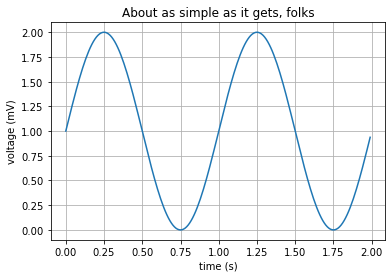

In [11]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
t = np.arange(0.0, 2.0, 0.01)
s = 1 + np.sin(2 * np.pi * t)

fig, ax = plt.subplots()
ax.plot(t, s)

ax.set(xlabel='time (s)', ylabel='voltage (mV)',
       title='About as simple as it gets, folks')
ax.grid()

fig.savefig("test.png")
plt.show()

Temp1:  [7.22893457e-01 8.37648871e-02 4.69270250e-02 ... 2.93127588e-04
 2.93125530e-04 2.93123473e-04]


ValueError: x and y must have same first dimension, but have shapes (10000,) and (1,)

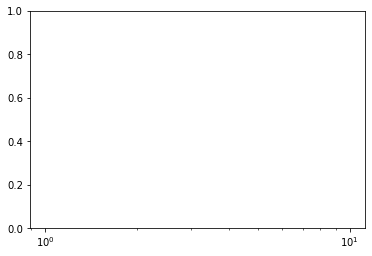

In [2]:
#
# Comparison of friction factors
#
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

epsOD3 = 0.001/3.7
# Data for plotting
Re = np.arange(10.0, 10.**6, 100)
f1 = 64/Re
f2 = 0.316*Re**0.25
# f3 = (1.1364*Re)**(-2)
Temp1 = epsOD3 +5.74/(Re**0.9)
print("Temp1: ",Temp1)
SJL = 1
SJL = math.log10(Temp1[0])
f4 = 0.25/(SJL)**2

fig, ax = plt.subplots()
matplotlib.pyplot.xscale("log")
ax.plot(Re, f1,f2,f4)

ax.set(xlabel='Re', ylabel='friction factor',
       title='Comparison')
ax.grid()

fig.savefig("fRe.png")
plt.show()

### <a name="Uncertainty"></a>Uncertainty
Here's some info.

<img src="Normal_distribution_and_scales.png" />


|$p$ | $z_p$|
| :---: | :--- |
| 0.8   | 1.281 |
0.90  | 1.645 |
0.95  | 1.960 |
0.98  | 2.326 |
0.99  | 2.576 |
0.995 | 2.807 |
0.998 | 3.0902 |
0.999 | 3.29053 |